In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random
from gymnasium import ObservationWrapper
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip  # Import from correct locationimport torch
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim

In [19]:
semilla = 42
np.random.seed(semilla)
random.seed(semilla)
torch.manual_seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs

In [20]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Metodos Auxiliares

In [21]:
def pi_star_from_Q(env, Q):  # Add seed parameter
    frames = []
    done = False
    pi_star = {}
    obs, info = env.reset(seed = semilla)
    active_features = env.last_active_features
    img = env.render()
    frames.append(img)
    actions = ""
    while not done:
        q_values = [np.sum(Q[active_features, a]) for a in range(env.action_space.n)]
        action = np.argmax(q_values)
        pi_star[tuple(obs)] = action
        actions += f"{action}, "
        obs, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
        active_features = env.last_active_features
    return pi_star, actions, frames

In [22]:
def plot_training_results(rewards):
    # Calculamos la media móvil para suavizar la gráfica
    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg, label='Recompensa promedio (media móvil)')
    plt.plot(rewards, alpha=0.2, label='Recompensa por episodio')
    plt.title('Entrenamiento del agente en Taxi-v3')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa total')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_learning_analysis(list_stats, episode_sizes):
    # Creamos una figura con 3 subplots
    plt.figure(figsize=(12, 9))

    # 1. Proporción de recompensas
    plt.subplot(3, 1, 1)
    indices = list(range(len(list_stats)))
    plt.plot(indices, list_stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)

    # 2. Tamaño de los episodios
    plt.subplot(3, 1, 2)
    indices = list(range(len(episode_sizes)))
    plt.plot(indices, episode_sizes)
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(indices[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Tamaño de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Número de pasos')
    plt.grid(True)
    plt.legend()

    # 3. Longitud del episodio en función del tiempo f(t) = len(episodiot)
    plt.subplot(3, 1, 3)
    cumulative_steps = np.cumsum(episode_sizes)
    plt.plot(cumulative_steps, episode_sizes, label='Longitud del episodio')
    # Media móvil para ver la tendencia
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(cumulative_steps[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Longitud del episodio vs Tiempo total')
    plt.xlabel('Tiempo total (pasos acumulados)')
    plt.ylabel('Longitud del episodio')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

In [24]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=semilla)

(array([-0.4452088,  0.       ], dtype=float32), {})

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
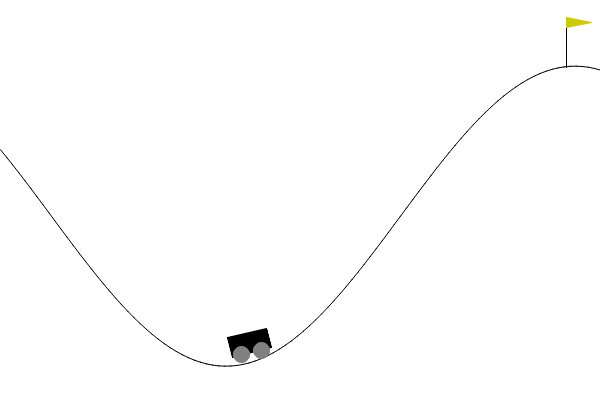

In [25]:
env.render()

In [26]:
env.action_space

Discrete(3)

In [27]:
env.observation_space, env.observation_space.low,  env.observation_space.high

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 array([-1.2 , -0.07], dtype=float32),
 array([0.6 , 0.07], dtype=float32))

# Tiling Code

In [28]:
#@title Extensión de la clase ObservationWrapper de Gymnasium para discretizar estados continuos

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=semilla)

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.

class TileCodingEnv(ObservationWrapper):
    """
    TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.
    Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas,
    permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.
    """

    def __init__(self, env, bins, low, high, n=4):
        """
        Inicializa el entorno env con tile coding.

        Parámetros:
        - env: entorno original de Gym.
        - bins: array o lista con el número de intervalos (bins) que hay que particionar cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - n: número de tilings (rejillas) a crear (por defecto 4).

        Se llama al método _create_tilings para generar las rejillas desplazadas.
        """
        super().__init__(env)  # Llama al constructor de la clase padre ObservationWrapper.

        # Guardamos atributos útiles para calcular las features solo una vez.
        self.bins = bins              # Ej.: np.array([10, 10])
        self.n_tilings = n            # Número de tilings.
        self.tile_size = int(np.prod(bins))  # Número de celdas en cada tiling.
        self.last_active_features = None     # Aquí se guardarán las features activas de la última observación

        self._high = high
        self._low = low

        self.tilings = self._create_tilings() # (bins, high, low, n)  # Crea y almacena las tilings.

        # el vector de observación tendrá C componentes. Por ejemplo, para 2 dimensiones × 4 tilings = C = 8.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()*n)



    def observation(self, obs):  # Es necesario sobreescribir este método de ObservationWrapper
        """
        Transforma una observación continua en una representación discreta usando tile coding.

        Parámetro:
        - obs: observación continua proveniente del entorno.

        Para cada tiling en self.tilings, se determina el índice (bin) para cada dimensión usando np.digitize.
        Se devuelve una lista de tuplas de índices, una por cada tiling.
        Antes de retornar, se calcula y almacena en self.last_active_features el conjunto de índices
        activos (flattened) usando _get_active_features().

        Retorna:
        - indices: lista de tuplas de índices, una por cada tiling.

        """
        indices = []  # Lista que almacenará los índices discretizados para cada tiling.
        for t in self.tilings:
            # Para cada tiling 't', se calcula el índice en el que se encuentra cada componente de la observación.
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)  # Se agrega la tupla de índices correspondiente a la tiling actual.

        # Calcula y guarda las features activas a partir de los índices obtenidos.
        self.last_active_features = self._get_active_features(indices)
        return indices # Retorna la lista de índices de todas las tilings.


    def _get_active_features(self, tiles):
        """
        Método privado para calcular los índices (features) activos en la función aproximada.

        Parámetro:
        - tiles: lista de tuplas (una por tiling) obtenida de observation(), donde cada tupla
          contiene los índices discretizados para cada dimensión.

        La función realiza lo siguiente:
          1. Convierte cada tupla de índices a un índice plano usando np.ravel_multi_index(tile, bins).
            - Dado que `tile` es una tupla de índices - por ejemplo, `(3, 5)` , y
            - dado que `bins` indica las particiones en cada dimensión - por ejemplo `bins = [10, 10]``
            - entonces `(3, 5)` se mapea a  3*10 + 5 = 35
            - Este índice plano identifica de forma única una celda dentro de una tiling.

          2. Asigna a cada tiling un bloque distinto en el vector de parámetros, de forma que:
             feature = (índice del tiling * tile_size) + índice plano.
             - Por ejemplo, con dos tilings, si en ambos se selecccionara el tile `(3, 5)`
             - Para el tiling 0 (i = 0), el flat_index será 35 (como se ha calculado antes)
             - Pero para el tiling 1 (i=1), el flat_index será 1*100+35=135

        Retorna:
        - features: lista de índices únicos (enteros) que indican las características activas.
        """
        features = []
        for i, tile in enumerate(tiles):
            # Convierte la tupla 'tile' a un índice plano.
            flat_index = np.ravel_multi_index(tile, self.bins)
            # Asigna a cada tiling un bloque único: para el tiling i, los índices van desde i*tile_size hasta (i+1)*tile_size - 1.
            feature = i * self.tile_size + flat_index
            features.append(feature)
        return features



    def _create_tilings(self): # , bins, high, low, n):
        """
        Crea 'n' tilings (rejillas) desplazadas para el tile coding.

        Parámetros:
        - bins: número de intervalos (bins) en cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - n: número de tilings a crear.

        El proceso consiste en:
         1. Generar un vector de desplazamientos base (displacement_vector) para cada dimensión.
         2. Para cada tiling, se ajustan los límites 'low' y 'high' añadiéndoles un pequeño desplazamiento aleatorio.
         3. Se calculan los tamaños de los segmentos en cada dimensión (segment_sizes).
         4. Se determinan desplazamientos específicos para cada dimensión y se aplican a los límites.
         5. Finalmente, se generan los buckets (límites discretos) para cada dimensión usando np.linspace.

        Retorna:
        - tilings: una lista donde cada elemento es una tiling (lista de arrays de buckets para cada dimensión).
        """
        # Se genera un vector de desplazamientos en cada dimensión en base a los números impares.
        # P.e. Si hay 2 dimensiones (len(bins) == 2): np.arange(1, 2 * 2, 2) -> np.arange(1, 4, 2) devuelve [1, 3]
        #      Si la dimensión 1 se desplaza en 1 unidad, en la dimensión 2 se desplazará en 3 unidades.
        # P.e. Si hay 3 dimensiones (len(bins) == 3): np.arange(1, 2 * 3, 2) -> np.arange(1, 6, 2) devuelve [1, 3, 5]
        # P.e. Si hay 4 dimensiones (len(bins) == 4): np.arange(1, 2 * 4, 2) -> np.arange(1, 8, 2) devuelve [1, 3, 5, 7]
        # Y así sucesivamente.
        # displacement_vector se ajusta automáticamente generando un array de números impares
        # Estos valores se usan posteriormente para calcular los desplazamientos específicos en cada dimensión al crear las tilings (rejillas).
        # ¿Por qué esos valores? Porque son los recomendados: los primeros números impares.
        displacement_vector = np.arange(1, 2 * len(bins), 2)


        tilings = []  # Lista que almacenará todas las tilings generadas.
        for i in range(0, self.n_tilings):
            # Para cada tiling 'i', se calculan nuevos límites 'low_i' y 'high_i' con un desplazamiento aleatorio.
            # El desplazamiento aleatorio se basa en el 20% de los límites originales.
            low_i = self._low  # - random.random() * 0.2 * low
            high_i = self._high # + random.random() * 0.2 * high

            # Vamos a calcular el desplazamiento específico para cada dimensión y cada mosaico.

            # Antes calculamos displacement_vector, que nos indica el desplazamiento en cada dimensión.
            # Como tenemos varios mosaicos, cada uno se tendrá que desplazar
            # en la mismas cantidades con respecto al mosaico anterior.
            # Esto se puede conseguir multiplicando el displacement_vector por el número de mosaico (i),
            # pero se toma el módulo n (número total de mosaicos).
            # De esta forma el desplazamiento de cada mosaico es diferente, dentro del rango [0, n-1]

            # P.e. Para n=4 mosaicos, y dos dimensiones, los vectores de desplazamiento de cada mosaico son:
            # i = 1: [1, 3] = [1, 3] * 1 % 4 = [1, 3] % 4
            # i = 2: [2, 2] = [1, 3] * 2 % 4 = [2, 6] % 4
            # i = 3: [3, 1] = [1, 3] * 3 % 4 = [3, 9] % 4
            # i = 4: [0, 0] = [1, 3] * 4 % 4 = [4, 12] % 4
            displacements = displacement_vector * i % self.n_tilings

            # Pero hay que escalar el desplazamiento a unidades reales en cada dimensión.
            # Para ello necesitamos calcular el tamaño de cada segmento (intervalo) en cada dimensión.
            segment_sizes = (high_i - low_i) / self.bins

            # Entonces usamos una fracción del tamaño del segmento para desplazar cada mosaico.
            # La fracción del tamaño del segmento viene dado por el tamaño del segmento dividido por el número de mosaicos.
            # Por ejemplo, si el tamaño de la celda es 0.5 en la primera dimensión y se consideran n=4 mosaicos, la fracción es 0.5/4=0.125
            # Según se ha calculado anteriormente, en el vector de desplazamiento,
            # la primera dimensión se desplaza en 1, 2, 3 y 0 unidades para los mosaicos 1, 2, 3, y 4, respectivamente.
            # Como la unidad es 0.125, entonces la primera dimensión de cada mosaico se desplaza en las cantidades:
            # 0.125 = 1 * 0.125,  0.25 = 2 * 0.125, 0.375 = 3 * 0.125, y  0 = 0 * 0.125.
            # Lo mismo se haría con el resto de dimensiones. En forma vectorial:
            # Es decir, el desplazamiento de cada mosaico en la primera dimensión es:
            # Tiling 1, [1, 3]: [1 * 0.125, 3 * 0.05] = [0.125, 0.15]
            # Tiling 2, [2, 2]: [2 * 0.125, 2 * 0.05] = [0.25, 0.10]
            # Tiling 3, [3, 1]: [3 * 0.125, 1 * 0.05] = [0.375, 0.05]
            # Tiling 4  [0, 0]: [0 * 0.125, 0 * 0.05] = [0, 0]
            displacements = displacements * (segment_sizes / self.n_tilings)

            dlow_i = low_i + displacements
            dhigh_i = high_i + displacements
            # print(f"Tiling {i}: Se aplican los desplazamientos {displacements} a los límites inferiores {low_i}->{dlow_i} y superiores {high_i}->{dhigh_i}.")

            # Para cada dimensión, se crean los buckets que dividen el intervalo de low_i a high_i en 'bins' partes,
            # generando 'l-1' puntos (límites) para cada dimensión.
            buckets_i = [np.linspace(j, k, l - 1) for j, k, l in zip(dlow_i, dhigh_i, bins)]

            # Se añade la tiling actual (lista de buckets para cada dimensión) a la lista de tilings.
            tilings.append(buckets_i)

        return tilings  # Retorna la lista completa de tilings.

In [29]:
#@title Generamos  mosaicos (tilings) con varios intervalos por dimensión. Al nuevo espacio lo llamaremos *tcenv*
tilings = 10  # Número de mosaicos
bins = np.array([20, 20])  # Número de intervalos en cada dimensión. 20 en cada una
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

In [30]:
#@title Comparamos el entorno original con el entorno con estados agregados

print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio original es: {env.step(env.action_space.sample())}")
print(f"\nEl espacio de estados modificado es: {tcenv.observation_space}. Mosaicos: {tcenv.n_tilings} \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")
print(f"Las caracterísiticas observadas han sido {tcenv.last_active_features} sobre {np.prod(tcenv.bins)*tcenv.n_tilings} parámetros")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio original es: (array([-0.4457913 , -0.00058252], dtype=float32), -1.0, False, False, {})

El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]). Mosaicos: 10 
Un estado para este nuevo espacio es: [(8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico
Las caracterísiticas observadas han sido [169, 569, 969, 1369, 1769, 2169, 2569, 2949, 3349, 3749] sobre 4000 parámetros


# Sarsa Semi-Gradiente

In [31]:
class SarsaSemiGradientAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        """
        Inicializa el agente SARSA con gradiente semilineal y Tile Coding.

        Parámetros:
        - env: Entorno de Gymnasium con Tile Coding.
        - alpha: Tasa de aprendizaje.
        - gamma: Factor de descuento (importancia de recompensas futuras).
        - epsilon: Probabilidad inicial de exploración (ε-greedy).
        - epsilon_decay: Factor de reducción de epsilon por episodio.
        - min_epsilon: Límite inferior de epsilon para evitar exploración excesiva.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Número de acciones posibles en el entorno
        self.num_actions = env.action_space.n

        # Número total de características en la codificación de tiles
        self.num_features = env.n_tilings * np.prod(env.bins)

        # Matriz de pesos inicializados en 0, de tamaño [n_features, n_actions]
        self.weights = np.zeros((self.num_features, self.num_actions))

    def get_q(self, active_features, action):
        """
        Calcula el valor de Q(s, a) como la suma de los pesos de las features activas.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado s.
        - action: Acción para la cual se calcula Q(s, a).

        Retorna:
        - Valor de Q(s, a) sumando los pesos correspondientes a las características activas.
        """
        return np.sum(self.weights[active_features, action])

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            return np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            q_values = [np.sum(self.weights[active_features, action]) for action in range(self.num_actions)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        """
        Reduce el valor de epsilon para disminuir la exploración con el tiempo.
        Se asegura de que epsilon no caiga por debajo de min_epsilon.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

    def update(self, active_features, active_features_next, a, a_next, reward, done, truncated):
        """
        Realiza la actualización de los pesos usando la ecuación de actualización de SARSA.

        Parámetros:
        - active_features: Lista de características activas en el estado actual.
        - active_features_next: Lista de características activas en el próximo estado.
        - a: Acción tomada en el estado actual.
        - a_next: Acción tomada en el próximo estado.
        - reward: Recompensa obtenida por tomar la acción a en el estado actual.
        - done: Indica si se llegó al estado terminal.
        - truncated: Indica si el episodio se truncó por un límite de pasos.

        """
        # Calcular Q(s,a) para el estado actual y la acción tomada
        q_sa = self.get_q(active_features, a)

        # Si no es estado terminal, calcular Q(s',a')
        if not (done or truncated):
            q_sap = self.get_q(active_features_next, a_next)
            delta = reward + self.gamma * q_sap - q_sa  # Error de TD
        else:
            delta = reward - q_sa  # En estado terminal, Q(s', a') no contribuye

        # Actualizar los pesos solo en las features activas para la acción 'a'
        for i in active_features:
            self.weights[i, a] += self.alpha * delta  # Regla de actualización de SARSA

        # Reducir epsilon después de cada actualización
        self.decay_epsilon()


In [32]:
# Hiperparámetros
num_episodes = 100000  # Número total de episodios de entrenamiento
GAMMA = 0.99  # Factor de descuento: importancia de las recompensas futuras (0 a 1)
ALPHA = 0.1  # Tasa de aprendizaje: cuánto se ajustan los pesos en cada actualización
EPSILON = 1.0  # Probabilidad de exploración inicial (epsilon-greedy)
EPSILON_DECAY = 0.999  # Factor de decaimiento de epsilon: reduce la exploración con el tiempo
MIN_EPSILON = 0.01  # Valor mínimo de epsilon: asegura una mínima exploración continua
max_steps = 1000  # Número máximo de pasos por episodio

In [33]:
# Inicializar el agente
agent = SarsaSemiGradientAgent(
    env=tcenv,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)


In [ ]:
# --- Bucle principal de entrenamiento con semigradiente SARSA ---
rewards_per_episode = []  # Para guardar la recompensa total de cada episodio
episodes_sizes = []
for episode in range(num_episodes):
    # Resetear el entorno (Gymnasium devuelve (obs, info))
    obs, info = tcenv.reset(seed=semilla)
    # El método observation() del wrapper actualiza internamente tcenv.last_active_features.
    active_features = tcenv.last_active_features
    # Seleccionar acción inicial usando epsilon-greedy
    a = agent.choose_action(active_features)

    total_reward = 0.0
    done = False

    for t in range(max_steps):
        # Ejecutar la acción 'a' y obtener la siguiente observación
        obs_next, reward, done, truncated, info = tcenv.step(a)
        total_reward += reward

        # Después de step, tcenv.last_active_features se actualiza para el nuevo estado s'
        active_features_next = tcenv.last_active_features
        # Seleccionar la siguiente acción a' (si el episodio continúa)
        if not (done or truncated):
            a_next = agent.choose_action(active_features_next)
        else:
            a_next = None  # No se usa si es terminal

        agent.update(active_features, active_features_next, a, a_next,reward, done, truncated)

        if done or truncated:
            break

        # Actualiza estado y acción para el siguiente paso
        active_features = active_features_next
        a = a_next

    rewards_per_episode.append(total_reward)
    episodes_sizes.append(t + 1)  # Agregar el tamaño del episodio a la lista
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Después de entrenar, puedes evaluar la política (por ejemplo, sin exploración)
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

Episode 1/100000, total reward: -200.0
Episode 2/100000, total reward: -200.0
Episode 3/100000, total reward: -200.0
Episode 4/100000, total reward: -200.0
Episode 5/100000, total reward: -200.0
Episode 6/100000, total reward: -200.0
Episode 7/100000, total reward: -200.0
Episode 8/100000, total reward: -200.0
Episode 9/100000, total reward: -200.0
Episode 10/100000, total reward: -200.0
Episode 11/100000, total reward: -200.0
Episode 12/100000, total reward: -200.0
Episode 13/100000, total reward: -200.0
Episode 14/100000, total reward: -200.0
Episode 15/100000, total reward: -200.0
Episode 16/100000, total reward: -200.0
Episode 17/100000, total reward: -200.0
Episode 18/100000, total reward: -200.0
Episode 19/100000, total reward: -200.0
Episode 20/100000, total reward: -200.0
Episode 21/100000, total reward: -200.0
Episode 22/100000, total reward: -200.0
Episode 23/100000, total reward: -200.0
Episode 24/100000, total reward: -200.0
Episode 25/100000, total reward: -200.0
Episode 2

In [ ]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)


In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
# Se pasa agent.weights en lugar de agent.Q porque estamos usando Sarsa Semi-Gradiente
pi, actions, frames = pi_star_from_Q(tcenv, agent.weights)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

In [ ]:
create_gif(frames, "SarsaSemiGradiente.mp4", fps=24)  # saves the GIF locally

# Q-Learning

In [ ]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        """
        Inicializa el agente de Q-Learning con Tile Coding.

        Parámetros:
        - env: Entorno de Gymnasium con codificación de tiles.
        - alpha: Tasa de aprendizaje.
        - gamma: Factor de descuento (importancia de recompensas futuras).
        - epsilon: Probabilidad inicial de exploración (ε-greedy).
        - epsilon_decay: Factor de reducción de epsilon por episodio.
        - min_epsilon: Límite inferior de epsilon para evitar exploración excesiva.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Número de acciones posibles en el entorno
        self.num_actions = env.action_space.n

        # Número total de características en la codificación de tiles
        self.num_features = env.n_tilings * np.prod(env.bins)

        # Inicializa la tabla Q con valores aleatorios pequeños para evitar sesgos iniciales
        self.Q = np.random.uniform(low=-1, high=1, size=(self.num_features, self.num_actions))

    def q_value(self, active_features, a):
        """
        Calcula el valor de Q(s,a) como la suma de los pesos para los índices activos.

        Parámetros:
        - active_features: Lista de índices de características activas para el estado s.
        - a: Acción seleccionada.

        Retorna:
        - Valor de Q(s,a) sumando los valores de las características activas para la acción a.
        """
        return self.Q[active_features, a].sum()

    def compute_q_values(self, active_features, num_actions):
        """
        Calcula Q(s,a) para todas las acciones posibles en el estado actual.

        Parámetros:
        - active_features: Lista de índices de características activas.
        - num_actions: Número total de acciones en el entorno.

        Retorna:
        - Un array 1D con los valores Q(s,a) para cada acción a.
        """
        q_vals = np.zeros(num_actions)
        for a in range(num_actions):
            q_vals[a] = self.q_value(active_features, a)  # Calcula Q(s,a) para cada acción
        return q_vals

    def choose_action(self, active_features):
        """
        Selecciona una acción usando la estrategia ε-greedy.

        Parámetros:
        - active_features: Lista de índices de características activas del estado actual.

        Retorna:
        - Acción seleccionada (exploratoria o explotadora).
        """
        if np.random.rand() < self.epsilon:
            # Exploración: Selecciona una acción aleatoria con probabilidad ε
            action = np.random.choice(self.num_actions)
        else:
            # Explotación: Selecciona la acción con el mayor valor Q estimado
            action = np.argmax(self.compute_q_values(active_features, self.num_actions))
        return action

    def update(self, active_features, active_features_next, a, reward):
        """
        Actualiza los valores de la función Q utilizando la ecuación de Bellman.

        Parámetros:
        - active_features: Lista de índices de características activas en el estado actual.
        - active_features_next: Lista de índices de características activas en el próximo estado.
        - a: Acción tomada en el estado actual.
        - reward: Recompensa recibida después de tomar la acción a.
        """
        # Calcula la actualización de Q usando la regla de actualización de Q-Learning
        self.Q[active_features, a] = (
            self.Q[active_features, a]  # Valor Q actual
            + self.alpha * (
                reward  # Recompensa inmediata
                + self.gamma * np.max(self.Q[active_features_next, :])  # Mejor Q futuro
                - self.Q[active_features, a]  # Diferencia con el valor Q actual
            )
        )

    def decay_epsilon(self):
        """
        Reduce el valor de epsilon para disminuir la exploración con el tiempo.
        Se asegura de que epsilon no caiga por debajo de min_epsilon.
        """
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)


In [ ]:
# Hiperparámetros
num_episodes = 5000  # Número total de episodios de entrenamiento
GAMMA = 0.95  # Factor de descuento: importancia de las recompensas futuras (0 a 1)
ALPHA = 0.1  # Tasa de aprendizaje: cuánto se ajustan los valores Q en cada actualización
EPSILON = 1.0  # Probabilidad de exploración inicial (epsilon-greedy)
EPSILON_DECAY = 0.999  # Factor de decaimiento de epsilon: reduce la exploración con el tiempo
MIN_EPSILON = 0.01  # Valor mínimo de epsilon: asegura una mínima exploración continua

In [ ]:
# Inicializar el agente
agent = QLearning(
    env=tcenv,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)


In [ ]:
# --- Bucle principal de entrenamiento con QLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

for episode in range(num_episodes):
    # Resetear el entorno al inicio de cada episodio
    obs, info = tcenv.reset(seed=semilla)
    # Obtener las características activas del estado inicial
    active_features = tcenv.last_active_features

    total_reward = 0  # Inicializar la recompensa total del episodio
    episode_steps = 0  # Inicializar el contador de pasos del episodio
    done = False  # Inicializar el indicador de episodio terminado

    # Bucle principal del episodio (hasta que termine o se trunque)
    while not done:
        # Seleccionar una acción usando la política epsilon-greedy
        a = agent.choose_action(active_features)
        # Ejecutar la acción en el entorno y obtener la siguiente observación, recompensa, etc.
        obs_next, reward, done, truncated, info = tcenv.step(a)
        # Obtener las características activas del siguiente estado
        active_features_next = tcenv.last_active_features

        # Si el episodio ha terminado o se ha truncado, salir del bucle
        if done or truncated:
            break
        else:
            # Actualizar la tabla Q con la experiencia obtenida
            agent.update(active_features, active_features_next, a, reward)

        # Actualizar el estado actual y el contador de pasos
        active_features = active_features_next
        episode_steps += 1
        total_reward += reward  # Acumular la recompensa del paso

    # Reducir epsilon después de cada episodio para disminuir la exploración
    agent.decay_epsilon()
    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)
    # Imprimir información del episodio
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

In [ ]:
plot_learning_analysis(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)



In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Q(tcenv, agent.Q)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

In [ ]:
create_gif(frames, "QLearning.mp4", fps=24)  # saves the GIF locally

# Deep Q-Learning

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class Buffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity



    def sample(self, batch_size):
      batch = random.sample(self.buffer, batch_size)  # Usa random.sample en lugar de np.random.choice
      return zip(*batch)  # Desempaca los valores correctamente


    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQN:
  def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size = 10000,  batch_size=64 ):

        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = Buffer(self.buffer_size)

        self.n_actions = env.action_space.n
        self.n_features = env.tile_size * env.n_tilings

        # Inicializar DQN y optimizador
        self.policy_net = NN(self.n_features, self.n_actions).to(device)
        self.target_net = NN(self.n_features, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)

  def select_action(self, state):
      if np.random.rand() < self.epsilon:
          return np.random.randint(self.n_actions)

      # Create a one-hot encoded state representation
      state_tensor = torch.zeros(1, self.n_features, device=device, dtype=torch.float32)  # Create a zero-filled tensor
      state_tensor[0, state] = 1  # Set the active features to 1

      with torch.no_grad():
          return self.policy_net(state_tensor).argmax().item()


  def optimize(self, state):
          batch = self.memory.sample(self.batch_size)
          states, actions, rewards, next_states, dones = map(np.array, batch)
          states_np = states # numpy array of list of active features
          next_states_np = next_states # numpy array of list of active features

          actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
          rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
          dones = torch.tensor(dones, dtype=torch.float32, device=device)
          states = torch.zeros(self.batch_size, self.n_features, device=device, dtype=torch.float32)  # Create a zero-filled tensor
          for i, s in enumerate(states_np):
              states[i, s] = 1  # Set the active features to 1
          next_states = torch.zeros(self.batch_size, self.n_features, device=device, dtype=torch.float32)  # Create a zero-filled tensor
          for i, ns in enumerate(next_states_np):
              next_states[i, ns] = 1  # Set the active features to 1

          q_values = self.policy_net(states).gather(1, actions).squeeze()
          next_q_values = self.target_net(next_states).max(1)[0]
          expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

          loss = nn.MSELoss()(q_values, expected_q_values.detach())
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

  def decay_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)



In [ ]:
gamma = 0.99  # Factor de descuento
alpha = 0.001  # Tasa de aprendizaje
epsilon = 1.0  # Probabilidad inicial de exploración
epsilon_min = 0.01  # Probabilidad mínima de exploración
epsilon_decay = 0.995  # Decaimiento de epsilon
buffer_size = 10000  # Tamaño del buffer de memoria
batch_size = 64  # Tamaño del minibatch
num_episodes = 20000  # Número total de episodios

In [ ]:
agent = DQN(tcenv, alpha, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size, batch_size)

In [ ]:
# --- Bucle principal de entrenamiento con QLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio
for episode in range(num_episodes):
    state, _ = tcenv.reset()
    state = tcenv.last_active_features  # Obtener las *active features*
    total_reward = 0
    episode_steps = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = tcenv.step(action)
        next_state = tcenv.last_active_features  # Obtener las *active features* del siguiente estado
        done = terminated or truncated

        agent.memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        episode_steps += 1

        if done:
            break

        if len(agent.memory) > agent.batch_size:
            # Entrenar DQN con una muestra del buffer
            agent.optimize(state)


    # Reducir epsilon
    agent.decay_epsilon()

    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)


    # Actualizar la red objetivo periódicamente
    if episode % 10 == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")


In [ ]:
plot_learning_analysis(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)

In [ ]:
def pi_star_from_Deep(env, agent):
    frames = []
    done = False
    pi_star = {}

    obs, info = env.reset(seed=semilla)
    active_features = env.last_active_features  # Obtener las active features iniciales
    img = env.render()
    frames.append(img)

    actions = ""
    agent.policy_net.eval()

    while not done:
        # Crear tensor de estado con las active features
        state_tensor = torch.zeros(1, agent.n_features, device=device, dtype=torch.float32)
        state_tensor[0, active_features] = 1  # Establecer las active features en 1

        with torch.no_grad():
            action = agent.policy_net(state_tensor).argmax().item()

        # Convert obs to a tuple if it's not already
        obs_tuple = tuple(obs) if isinstance(obs, (list, np.ndarray)) else obs
        pi_star[obs_tuple] = action
        actions += f"{action}, "

        obs, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)

        done = terminated or truncated
        active_features = env.last_active_features  # Actualizar active features

    return pi_star, actions, frames

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Deep(tcenv, agent)

# Renderizar el entorno para obtener la imagen final
img = tcenv.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", tcenv.render())
print()

In [ ]:
create_gif(frames, "DeepQLearning.mp4", fps=24)  # saves the GIF locally